# Testing of a new library for reading OSM PBF files using DuckDB: QuackOSM

---

## Import the main library and other supporting ones

In [11]:
import quackosm as qosm
import pandas as pd
import duckdb

---

## Let's try some first examples

### Load data as GeoDataFrame

In [3]:
# Loading Berlin's datas found on "https://download.geofabrik.de/"
qosm.convert_pbf_to_geodataframe('data/berlin-latest.osm.pbf')

,tags,geometry
feature_id,,
node/1722876789,"{'river:waterway_distance': '26', 'seamark:dis...",POINT (13.06828 52.39526)
node/617225609,"{'maxheight': '6.27', 'maxheight_referenceleve...",POINT (13.06278 52.39295)
node/2727015653,{'barrier': 'gate'},POINT (13.08744 52.38818)
node/1456258887,"{'crossing:barrier': 'no', 'railway': 'level_c...",POINT (13.09465 52.39162)
node/617362180,"{'name': 'S Babelsberg/Wattstraße', 'public_tr...",POINT (13.09417 52.39159)
...,...,...
way/312338059,"{'leaf_type': 'broadleaved', 'natural': 'wood'}","POLYGON ((13.74445 52.41704, 13.74439 52.41698..."
way/388929487,{'natural': 'wood'},"POLYGON ((13.74758 52.41744, 13.74755 52.41747..."
way/312338064,{'natural': 'wood'},"POLYGON ((13.74778 52.41737, 13.74782 52.41734..."


### Convert PBF to GeoParquet


In [8]:
gpq_path = qosm.convert_pbf_to_parquet('data/berlin-latest.osm.pbf')

gpq_path.as_posix()

'files/berlin-latest_nofilter_noclip_compact_sorted.parquet'

### Try to read this GeoParquet file using Pandas

In [9]:
df = pd.read_parquet('files/berlin-latest_nofilter_noclip_compact_sorted.parquet')
print(df.head())

        feature_id                                               tags  \
0  node/1722876789  [(river:waterway_distance, 26), (seamark:dista...   
1   node/617225609  [(maxheight, 6.27), (maxheight_referencelevel,...   
2  node/2727015653                                  [(barrier, gate)]   
3  node/1456258887  [(crossing:barrier, no), (railway, level_cross...   
4   node/617362180  [(name, S Babelsberg/Wattstraße), (public_tran...   

                                            geometry  
0  b'\x01\x01\x00\x00\x00\xb80\x1c\x19\xf5"*@\xfa...  
1  b'\x01\x01\x00\x00\x00\x17\xdb\xff[$ *@29\xb53...  
2  b'\x01\x01\x00\x00\x00\xd1t\x1by\xc5,*@\xe8\x0...  
3  b'\x01\x01\x00\x00\x00\xbd\xea\xb7ev0*@\xba\xc...  
4  b'\x01\x01\x00\x00\x00\x96vj.70*@\x14\xba\xa6\...  


### Inspect the file with DuckDB

In [11]:
duckdb.load_extension('spatial')
duckdb.read_parquet(str(gpq_path)).order("feature_id")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────────────────────────┐
│    feature_id    │                                                   tags                                                    │           geometry            │
│     varchar      │                                           map(varchar, varchar)                                           │           geometry            │
├──────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────────────────────────┤
│ node/10000041539 │ {noexit=yes}                                                                                              │ POINT (13.542045 52.569623)   │
│ node/10000166557 │ {amenity=bench, backrest=yes, material=wood, seats=4}                                                     │ POINT (13.4299284 52.4291085) │
│ node/10000166558 │ {leaf_cycle=d

---

As we can clearly see is better to use DuckDB over Pandas if we want to analyze and inspect the file DataSet.
Let's try out other examples directly from the QuackOSM website [https://kraina-ai.github.io/quackosm/0.2.0/examples/pbf_file_reader/]

---

## PBF File Reader Testing: part 1

### Download all the buildings in Turin, Italy

In [49]:
from quackosm import PbfFileReader
import urllib.request
import osmnx as ox
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
italy_pbf_url = "https://download.geofabrik.de/europe/italy-latest.osm.pbf"
italy_pbf_file = "italy.osm.pbf"
urllib.request.urlretrieve(italy_pbf_url, italy_pbf_file)

('italy.osm.pbf', <http.client.HTTPMessage at 0x2594a7ca350>)

In [2]:
turin_gdf = ox.geocode_to_gdf("Turin, IT")
turin_gdf

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"MULTIPOLYGON (((7.57783 45.04183, 7.57985 45.0...",7.577835,45.006792,7.773339,45.140217,84660071,relation,43992,45.067755,7.682489,boundary,administrative,16,0.759488,city,Turin,"Turin, Torino, Piedmont, Italy"


In [5]:
reader = PbfFileReader(
    geometry_filter=turin_gdf.geometry.iloc[0], tags_filter={"building": True}
)

turin_buildings_gpq = reader.convert_pbf_to_gpq("italy.osm.pbf")
turin_buildings_gpq

Output()

Encountered MemoryError during operation. Retrying with lower number of rows per group (100000).

Finished operation in 0:07:46

WindowsPath('files/italy_ae99e3d9_7be2938d_exploded_sorted.parquet')

### Read all the features using DuckDB

In [11]:
import duckdb

connection = duckdb.connect()

connection.load_extension("parquet")
connection.load_extension("spatial")

features_relation = connection.read_parquet(str(turin_buildings_gpq)).project(
    "* REPLACE (ST_GeomFromWKB(ST_AsWKB(geometry)) AS geometry)"
)

features_relation # The results aren't so good to read as the Turin's data features is huge

┌───────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬─────────────┐
│    feature_id     │                                                                                                                                                                                                                                                                                    geometry                                                                                                  

### Count all the buildings in Turin

In [12]:
features_relation.count("feature_id")

┌───────────────────┐
│ count(feature_id) │
│       int64       │
├───────────────────┤
│             39388 │
└───────────────────┘

---

## PBF File Reader Testing: part 2

### Download all the main roads for Sweden

In [13]:
# Filtering the data only by tags, with tags in exploded form

highways_filter = {
    "highway": [
        "motorway",
        "trunk",
        "primary",
        "secondary",
        "tertiary",
    ]
}

In [14]:
sweden_pbf_url = "http://download.geofabrik.de/europe/sweden-latest.osm.pbf"
sweden_pbf_file = "sweden.osm.pbf"
urllib.request.urlretrieve(sweden_pbf_url, sweden_pbf_file)

reader = PbfFileReader(geometry_filter=None, tags_filter=highways_filter)
sweden_features_gpq = reader.convert_pbf_to_gpq(sweden_pbf_file)
sweden_features_gpq

Output()

Finished operation in 0:02:10

WindowsPath('files/sweden_87e7b741_noclip_exploded_sorted.parquet')

In [25]:
features_relation = connection.read_parquet(str(sweden_features_gpq)).project(
    "* REPLACE (ST_GeomFromWKB(ST_AsWKB(geometry)) AS geometry)"
)
features_relation

┌───────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────┐
│  feature_id   │                                                                                                         

### Count loaded roads

In [26]:
features_relation.count("feature_id")

┌───────────────────┐
│ count(feature_id) │
│       int64       │
├───────────────────┤
│            177716 │
└───────────────────┘

### Calculate roads length

In [27]:
length_in_meters = (
    features_relation.project(
        "ST_Length(ST_Transform(geometry, 'EPSG:4326', 'EPSG:3301')) AS road_length"
    )
    .sum("road_length")
    .fetchone()[0]
)
length_in_km = length_in_meters / 1000
length_in_km

217514.09050911973

### Plot the roads using GeoPandas

With fast loading of geoparquet files using geoarrow.pyarrow library.

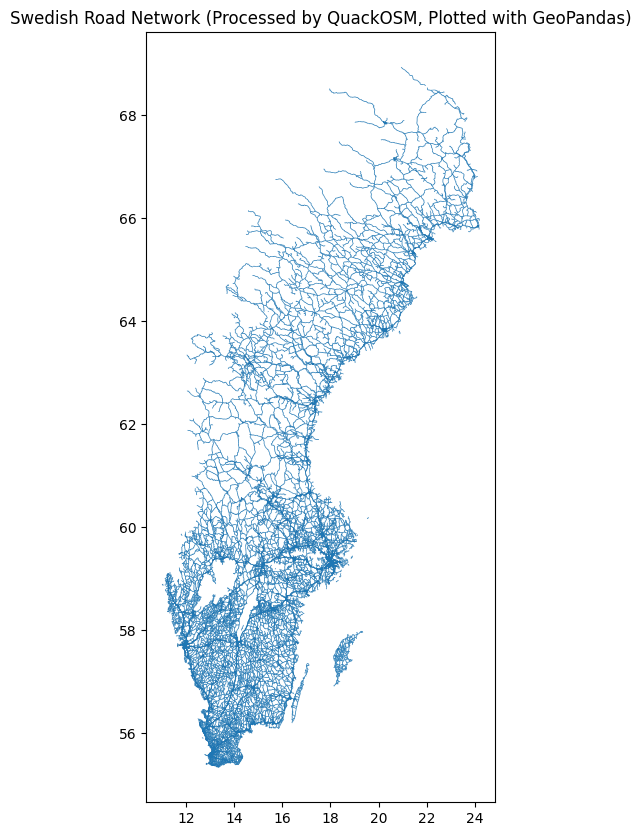

In [53]:
import geopandas as gpd
import matplotlib.pyplot as plt

parquet_table = gpd.read_parquet(sweden_features_gpq)

parquet_table.plot(figsize=(10, 10), linewidth=0.5)
plt.title("Swedish Road Network (Processed by QuackOSM, Plotted with GeoPandas)")
plt.show()

---

## PBF File Reader Testing: part 3

### Download all data for Liechtenstein

In [55]:
liechtenstein_pbf_url = "https://download.geofabrik.de/europe/liechtenstein-latest.osm.pbf"
liechtenstein_pbf_file = "liechtenstein.osm.pbf"
urllib.request.urlretrieve(liechtenstein_pbf_url, liechtenstein_pbf_file)

# Here explode_tags is set to False explicitly,
# but it would set automatically when not filtering the data
reader = PbfFileReader(geometry_filter=None, tags_filter=None)
liechtenstein_features_gpq = reader.convert_pbf_to_gpq(
    liechtenstein_pbf_file, explode_tags=False
)
liechtenstein_features_gpq

Output()

Finished operation in 0:00:13

WindowsPath('files/liechtenstein_nofilter_noclip_compact_sorted.parquet')

In [64]:
features_relation = connection.read_parquet(str(liechtenstein_features_gpq)).project(
    "* REPLACE (ST_GeomFromWKB(ST_AsWKB(geometry)) AS geometry)"
)
features_relation

┌─────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

###  Return data as GeoDataFrame

`PbfFileReader` can also return the data in the GeoDataFrame form.

In [65]:
features_gdf = reader.get_features_gdf(liechtenstein_pbf_file)
features_gdf

,tags,geometry
feature_id,,
node/540308211,{'power': 'tower'},POINT (9.53724 46.98628)
node/1338490716,{'power': 'tower'},POINT (9.53428 46.98876)
node/540308206,{'power': 'tower'},POINT (9.53134 46.99121)
node/540308180,{'power': 'tower'},POINT (9.52855 46.99365)
node/540308170,{'power': 'tower'},POINT (9.52576 46.99609)
...,...,...
way/439890023,{'natural': 'cliff'},"LINESTRING (9.60433 47.06468, 9.60382 47.06464..."
way/1195535494,{'natural': 'grassland'},"POLYGON ((9.60181 47.06237, 9.60136 47.06238, ..."
node/540308216,"{'line_attachment': 'suspension', 'power': 'to...",POINT (9.54003 46.98396)


### Plot the forests using GeoPandas

Filter all polygons and features with `landuse=forest`.

<Axes: >

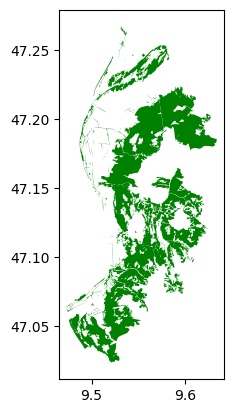

In [66]:
features_gdf[
    features_gdf.geom_type.isin(("Polygon", "MultiPolygon"))
    & features_gdf.tags.apply(lambda x: "landuse" in x and x["landuse"] == "forest")
].plot(color="green")

---